# Demo notebook for GPGPU project, 2021 fall session

**Subject: lightspeed barcode detector in images / video streams.**

## Imports

In [22]:
!pip freeze

argon2-cffi==21.1.0
attrs==21.2.0
backcall==0.2.0
bleach==4.1.0
cffi==1.15.0
cycler==0.11.0
debugpy==1.5.1
decorator==5.1.0
defusedxml==0.7.1
entrypoints==0.3
imageio==2.10.1
ipykernel==6.4.2
ipython==7.28.0
ipython-genutils==0.2.0
ipywidgets==7.6.5
jedi==0.18.0
Jinja2==3.0.2
joblib==1.1.0
jsonschema==4.1.2
jupyter==1.0.0
jupyter-client==7.0.6
jupyter-console==6.4.0
jupyter-core==4.9.1
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.2
kiwisolver==1.3.2
llvmlite==0.37.0
MarkupSafe==2.0.1
matplotlib==3.4.3
matplotlib-inline==0.1.3
mistune==0.8.4
nbclient==0.5.4
nbconvert==6.2.0
nbformat==5.1.3
nest-asyncio==1.5.1
networkx==2.6.3
notebook==6.4.5
numba==0.54.1
numpy==1.20.0
opencv-python-headless==4.5.4.58
packaging==21.2
pandocfilters==1.5.0
parso==0.8.2
pexpect==4.8.0
pickleshare==0.7.5
Pillow==8.4.0
prometheus-client==0.11.0
prompt-toolkit==3.0.21
ptyprocess==0.7.0
pycparser==2.20
Pygments==2.10.0
pyparsing==2.4.7
pyrsistent==0.18.0
python-dateutil==2.8.2
PyWavelets==1.1.1
pyzmq==22.

In [1]:
import numpy as np
import skimage
import sklearn
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage.util.shape import view_as_blocks

In [3]:
import numba

## Constants

In [4]:
scale_factor = 1

In [11]:
pool_size = 31
postproc_size = 5

## Feature extraction helpers

In [5]:
@numba.jit()
def _compute_features(img, pool_size):
    n_filters = 2  # 3
    img_features = np.zeros(img.shape[:2] + (n_filters,), dtype=np.uint8)
    
    sobelx = np.float32([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobely = np.rot90(sobelx, k=-1)
    
    for ii in range(1,img.shape[0]-1):
        for jj in range(1, img.shape[1]-1):
            patch = img[ii-1:ii+2,jj-1:jj+2]
            # sobel x
            img_features[ii,jj,0] = np.abs(np.sum(sobelx * patch))
            # sobel y
            img_features[ii,jj,1] = np.abs(np.sum(sobely * patch))
#             # flat filter
#             img_features[ii, jj, 2] = 255 - (np.max(patch) - np.min(patch))
            
    return img_features

In [6]:
# cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5))  # produces array with dtype=uint8

In [7]:
def image_to_features(path, scale_factor, pool_size, postproc_size):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    for _ in range(scale_factor):
        img = cv2.pyrDown(img)
    
    # compute gradients
    img_features = _compute_features(img, pool_size)
    
    # pool gradient info over patches
    patchs_y, patchs_x = np.array(img.shape) // pool_size
    features_crop = img_features[:pool_size*patchs_y, :pool_size*patchs_x]
    features_patchs = view_as_blocks(features_crop, block_shape=(pool_size, pool_size, 2))
    
    response = np.zeros((patchs_y, patchs_x), dtype=np.uint8)
    for ii in range(patchs_y):
        for jj in range(patchs_x):
            response[ii, jj] = np.clip(
                (np.mean(features_patchs[ii, jj, ..., 0])
                - np.mean(features_patchs[ii, jj, ..., 1])),
#                 * np.mean(features_patchs[ii, jj, ..., 2]),
            0, 255)
    
    # apply horizontal closing to remove small vertical elements and connect small gaps
    se_size = postproc_size
    se = np.zeros((se_size,se_size), dtype=np.uint8)
    se[se_size//2-1:se_size//2+2,:] = 1
    response = cv2.morphologyEx(response, cv2.MORPH_CLOSE, se)
    
    return img, img_features, response

In [8]:
def image_to_targets(path, scale_factor, patch_size):
    target = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    for _ in range(scale_factor):
        target = cv2.pyrDown(target)
    patchs_y, patchs_x = np.array(target.shape) // patch_size
    target_crop = target[:patch_size*patchs_y, :patch_size*patchs_x]
    target_patchs = view_as_blocks(target_crop, block_shape=(patch_size, patch_size))
    barcode_patchs =  np.sum(target_patchs>0, axis=(2,3)) > patch_size**2/2

    return target_crop, barcode_patchs

## Test images

In [9]:
img_path = !find "../train_db/" -iname "*.jpg" | sort
img_path

['../train_db/PXL_20211029_132457978.jpg',
 '../train_db/PXL_20211101_170122638.jpg',
 '../train_db/PXL_20211101_175643604.jpg',
 '../train_db/PXL_20211102_103714125.jpg']

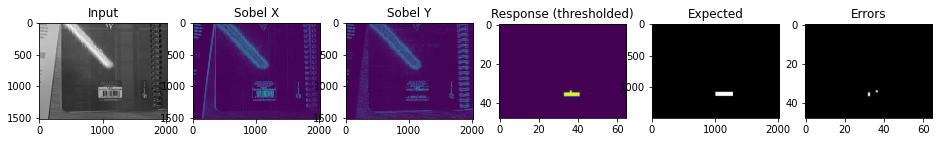

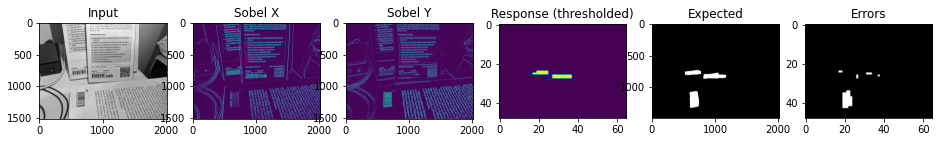

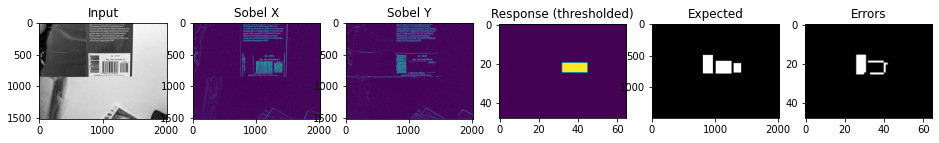

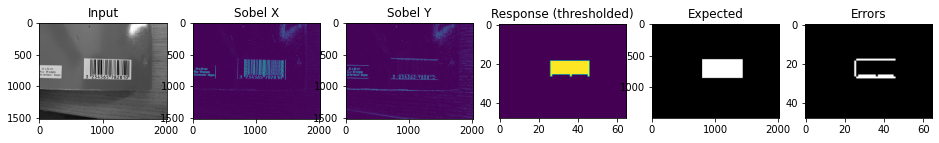

In [12]:
for pp in img_path:
    plt.figure(figsize=(16,4))
    img, features, response = image_to_features(pp, scale_factor, pool_size, postproc_size)
    plt.subplot(161)
    plt.imshow(img, cmap='gray')
    plt.title("Input")

    plt.subplot(1,6,2)
    plt.imshow(features[..., 0])
    plt.title("Sobel X")
    plt.subplot(1,6,3)
    plt.imshow(features[..., 1])
    plt.title("Sobel Y")

        
    plt.subplot(1,6,4)
    response_thresh = response  > response.max()*0.5
    plt.imshow(response_thresh)
    plt.title("Response (thresholded)")
    
    
    ppt = pp[:-4] + "-GT.png"
    target_img, expected = image_to_targets(ppt, scale_factor, pool_size)
    plt.subplot(165)
    plt.imshow(target_img, cmap='gray')
    plt.title("Expected")
    
    plt.subplot(166)
    plt.imshow(expected != response_thresh, cmap='gray')
    plt.title("Errors")

# Illustrations

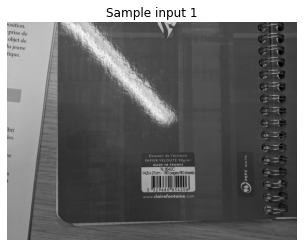

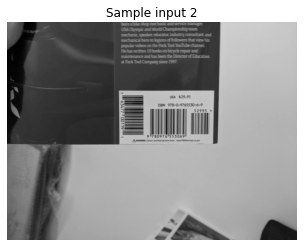

In [13]:
img1 = cv2.imread("../train_db/PXL_20211029_132457978.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img1, cmap='gray'); plt.axis("off"); plt.title("Sample input 1"); plt.show()
img2 = cv2.imread("../train_db/PXL_20211101_175643604.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(img2, cmap='gray'); plt.axis("off"); plt.title("Sample input 2"); plt.show()

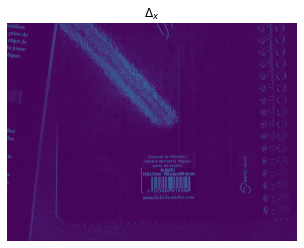

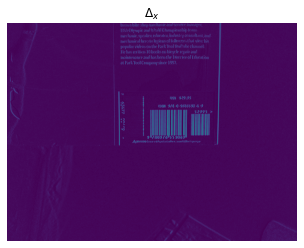

In [14]:
sobx1 = cv2.Sobel(img1, -1, dx=1, dy=0)
plt.imshow(sobx1); plt.axis("off"); plt.title("$\Delta_x$"); plt.show()
sobx2 = cv2.Sobel(img2, -1, dx=1, dy=0)
plt.imshow(sobx2); plt.axis("off"); plt.title("$\Delta_x$"); plt.show()

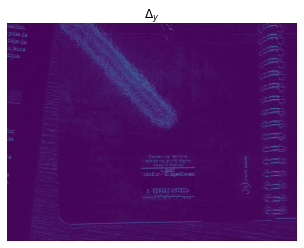

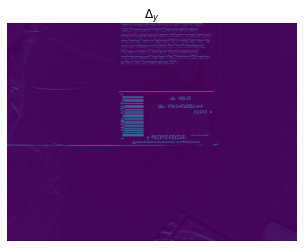

In [15]:
soby1 = cv2.Sobel(img1, -1, dx=0, dy=1)
plt.imshow(soby1); plt.axis("off"); plt.title("$\Delta_y$"); plt.show()
soby2 = cv2.Sobel(img2, -1, dx=0, dy=1)
plt.imshow(soby2); plt.axis("off"); plt.title("$\Delta_y$"); plt.show()

In [16]:
def gpool(grad_img, pool_size):
# pool gradient info over patches
    patchs_y, patchs_x = np.array(grad_img.shape) // pool_size
    crop = grad_img[:pool_size*patchs_y, :pool_size*patchs_x]
    features_patchs = view_as_blocks(crop, block_shape=(pool_size, pool_size))
    
    response = np.zeros((patchs_y, patchs_x), dtype=np.int32)
    for ii in range(patchs_y):
        for jj in range(patchs_x):
            response[ii, jj] = np.mean(features_patchs[ii, jj])
    return response

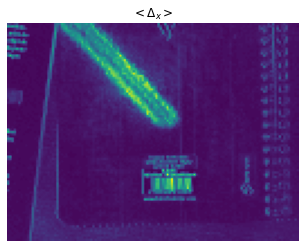

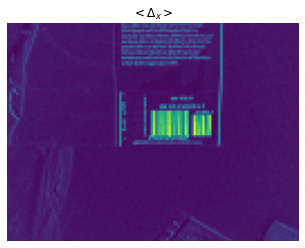

In [17]:
pool_sobx1 = gpool(sobx1, pool_size)
plt.imshow(pool_sobx1); plt.axis("off"); plt.title("$<\Delta_x>$"); plt.show()
pool_sobx2 = gpool(sobx2, pool_size)
plt.imshow(pool_sobx2); plt.axis("off"); plt.title("$<\Delta_x>$"); plt.show()

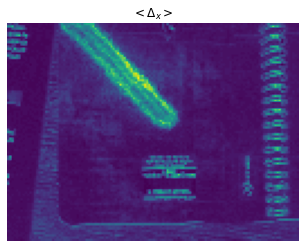

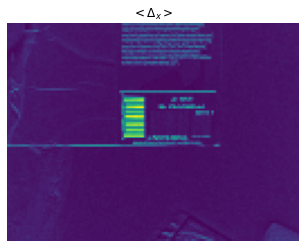

In [18]:
pool_soby1 = gpool(soby1, pool_size)
plt.imshow(pool_soby1); plt.axis("off"); plt.title("$<\Delta_x>$"); plt.show()
pool_soby2 = gpool(soby2, pool_size)
plt.imshow(pool_soby2); plt.axis("off"); plt.title("$<\Delta_x>$"); plt.show()

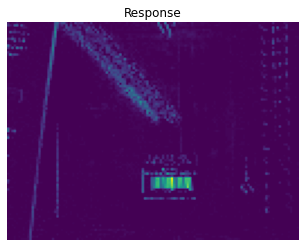

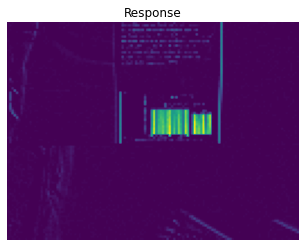

In [19]:
resp1 = np.clip(pool_sobx1 - pool_soby1, 0, 255)
plt.imshow(resp1); plt.axis("off"); plt.title("Response"); plt.show()
resp2 = np.clip(pool_sobx2 - pool_soby2, 0, 255)
plt.imshow(resp2); plt.axis("off"); plt.title("Response"); plt.show()

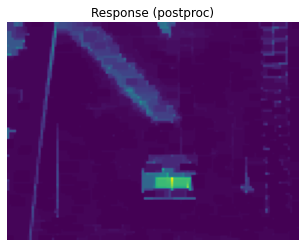

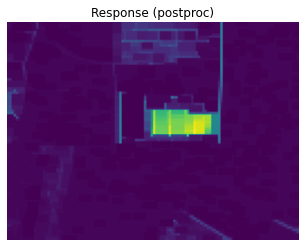

In [20]:
se_size = postproc_size
se = np.zeros((se_size,se_size), dtype=np.uint8)
se[se_size//2-1:se_size//2+2,:] = 1

resp1 = cv2.morphologyEx(np.uint8(resp1), cv2.MORPH_CLOSE, se)
plt.imshow(resp1); plt.axis("off"); plt.title("Response (postproc)"); plt.show()
resp2 = cv2.morphologyEx(np.uint8(resp2), cv2.MORPH_CLOSE, se)
plt.imshow(resp2); plt.axis("off"); plt.title("Response (postproc)"); plt.show()

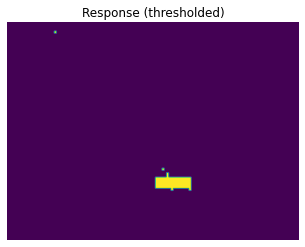

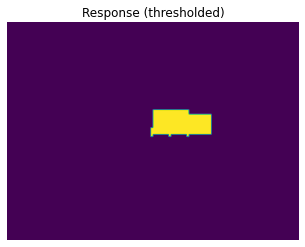

In [21]:
resp1 = resp1 > resp1.max() * 0.5
plt.imshow(resp1); plt.axis("off"); plt.title("Response (thresholded)"); plt.show()
resp2 = resp2 > resp2.max() * 0.5
plt.imshow(resp2); plt.axis("off"); plt.title("Response (thresholded)"); plt.show()